In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import keras
from keras.layers import LSTM, Dropout, Dense, Flatten, Input, LeakyReLU, BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.utils import plot_model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import graphviz
import pydot

In [2]:
df = pd.read_csv("C:\\Users\\Kevin\\Desktop\\Data3001\datascience-cis-2022.csv")
df['time'] = pd.to_datetime(df['time'], unit='ns')

In [3]:
df_dev1 = df[df["device_mac"] == "bd:0d:8e:c5"]
df_dev1.set_index('time', inplace=True)

In [4]:
df_1d = df_dev1['2022-09-02 00:24:59.417':'2022-09-03 00:25:00.417']
df_1d2 = df_dev1['2022-09-09 00:24:59.417':'2022-09-10 00:25:00.620']
df_1h = df_dev1['2022-09-02 00:24:59.417':'2022-09-02 01:25:00.000']

In [7]:
# picking devices to use first 10 hand picked, next 10 random scroll between the first two letters

# 4 devices which will show 0, 3 devices being from port 80, 4 devices with regular random output
# 21:fa:2d:cf - all 0 values
# 21:fa:3d:83 - only port 80
# 21:fd:4f:87 - only frominternet80
# 5a:ff:cb:09 - only to internet RSVP with 8 packets, when LSTM will only show 0 for all
# 5a:ff:cb:0d - only frominternet80
# ac:f2:02:b4 - all 0 values
# ac:ee:3e:ad - normal flow look
# bd:0d:a9:e4 - normal flow look
# ee:dd:38:4e - normal flow look
# ee:dd:3b:34 - normal with - tolocal being 0
# ee:dd:3b:32 - all 0 values

# random
# 21:fd:48:43
# 21:fa:37:ef
# 5a:ff:ad:d8
# 5a:ff:ba:4a 
# ac:ee:3e:a2 
# ac:f2:02:b4
# bd:0d:af:33
# bd:0d:8e:c5
# ee:dd:49:31
# ee:dd:34:07

In [ ]:
# this device will have plots, the rest of the devices will be copy and paste

In [5]:
# get rid of 0 columns - reasons, features are sum of all values per device for the 2 weeks
# port 443 is all 0
# maybe tolocal67 as the values are either around 9000 packets, 4500 packets or 0, with some anomalies
# maybe tolocal5353 as most of the devices are 0 with some having 13 or 12 packets
              
#'ToLocalUDPPort5353IP224.0.0.251/32ByteCount', 'ToLocalUDPPort67IP255.255.255.255/32ByteCount']]

dev1 = df_1d[['FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
                    'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                    'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
                    'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
                    'ToInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
                    'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                    'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount']]
dev1_plt = df_1h[['FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
                    'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                    'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
                    'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
                    'ToInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
                    'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                    'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount']]

In [6]:
dev1_norm = (dev1-dev1.min())/(dev1.max()-dev1.min())
dev1_plt_norm = (dev1_plt-dev1_plt.min())/(dev1_plt.max()-dev1_plt.min())

In [7]:
dev1_norm = dev1_norm.fillna(0)
dev1_plt_norm = dev1_plt_norm.fillna(0)

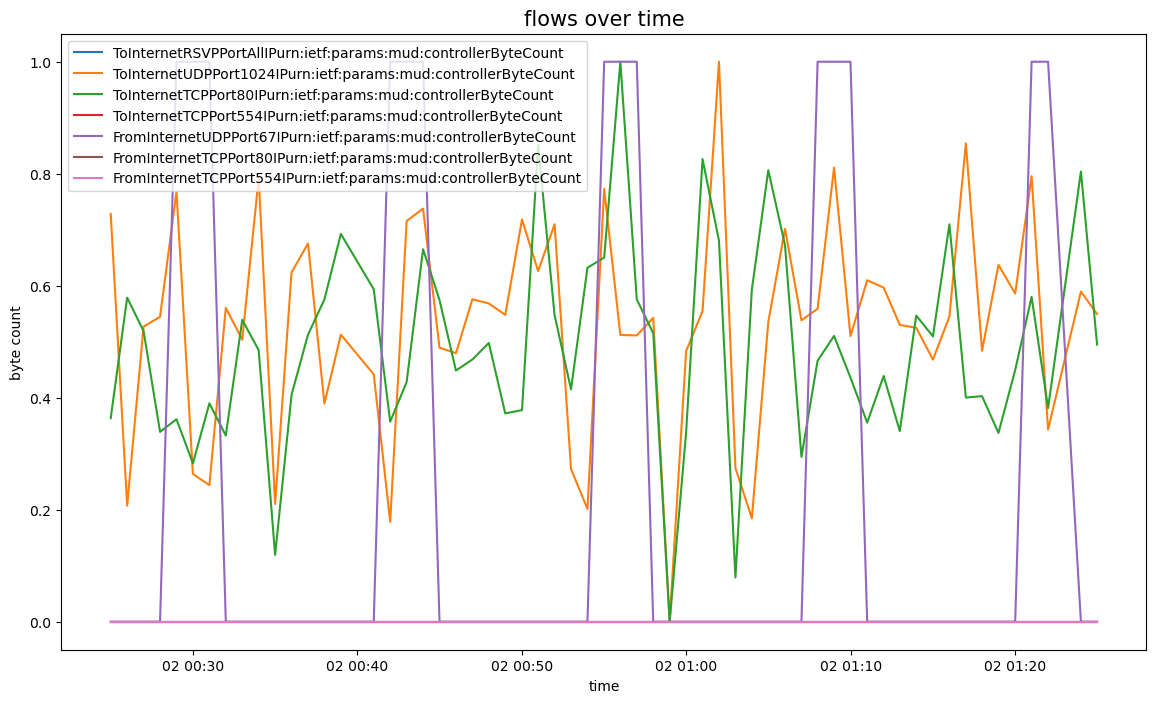

In [116]:
import seaborn as sns
plt.figure(figsize=(14,8))
plt.title("flows over time", fontdict={"fontsize": 15})

lines = {'FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
         'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
         'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
         'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount', 
         'ToInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
         'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
         'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'}
for line in lines:
    ax = sns.lineplot(x='time', y=line, data=dev1_plt_norm)
    
plt.ylabel('byte count')
plt.legend(lines)

In [8]:
dev1_clean = dev1_norm.loc[:, (dev1_norm != 0).any(axis=0)]

In [9]:
dev1_clean.head(10)

,FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount,ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount,ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount
time,,,,
2022-09-02 00:24:59.417,0.0,0.333333,0.138546,0.147963
2022-09-02 00:25:59.386,0.0,0.333333,0.173852,0.119089
2022-09-02 00:26:59.365,0.0,0.333333,0.164046,0.136821
2022-09-02 00:27:59.422,0.0,0.333333,0.134518,0.137797
2022-09-02 00:28:59.461,0.5,0.333333,0.138213,0.150187
2022-09-02 00:29:59.399,0.5,0.333333,0.125291,0.122232
2022-09-02 00:30:59.533,0.5,0.333333,0.142872,0.121132
2022-09-02 00:31:59.428,0.0,0.333333,0.133437,0.138675
2022-09-02 00:32:59.459,0.0,0.333333,0.167350,0.135522


In [10]:
train_size = int(0.8 * len(dev1_clean))
test_size = len(dev1_clean) - train_size
train, test = dev1_clean.iloc[0:train_size], dev1_clean.iloc[train_size:len(dev1_clean)]

In [11]:
def batch(X, y, time_steps=1):
    series_X, series_Y = [], []
    for i in range(len(X) - time_steps):
        new = X.iloc[i: (i + time_steps)].to_numpy()
        series_X.append(new)
        series_Y.append(y.iloc[i + time_steps])
    return np.array(series_X), np.array(series_Y)

In [ ]:
FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount
ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount
ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount

In [12]:
TIME = 20

X_train, y_train = batch(train, train['FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test, y_test = batch(test, test['FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

In [16]:
y_train.shape

(1078,)

In [14]:
from datetime import datetime as dt
model = keras.Sequential()
model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units = 32, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(12, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

In [25]:
start = dt.now()
history_from67 = model.fit(X_train, y_train,
                          epochs = 30,
                          batch_size = 10,
                          validation_split = 0.1,
                          shuffle = False,
                          verbose = 1)
running_secs = (dt.now() - start).seconds
print('LSTM runtime', running_secs, 'seconds')

Epoch 1/30
97/97 [==============================] - 1s 9ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 2/30
97/97 [==============================] - 1s 9ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 3/30
97/97 [==============================] - 1s 9ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 4/30
97/97 [==============================] - 1s 9ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 5/30
97/97 [==============================] - 1s 8ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 6/30
97/97 [==============================] - 1s 9ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 7/30
97/97 [==============================] - 1s 9ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 8/30
97/97 [==============================] - 1s 9ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 9/30
97/97 [==============================] - 1s 8ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 10/30
97/97 [==============================] - 1s 8ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 11/30
97/97 [

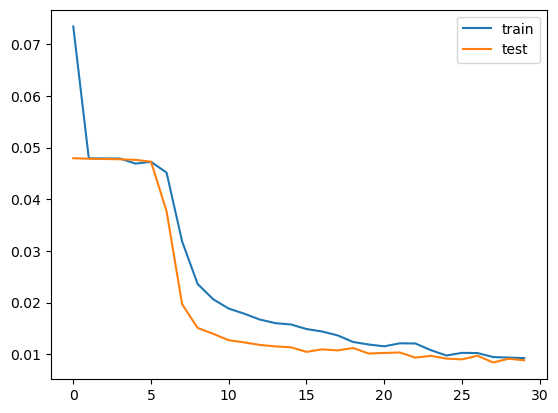

In [141]:
plt.plot(history_from67.history['loss'], label='train')
plt.plot(history_from67.history['val_loss'], label='test')
plt.legend()
plt.show()

In [19]:
y_pred_67 = model.predict(X_test)

9/9 [==============================] - 1s 3ms/step


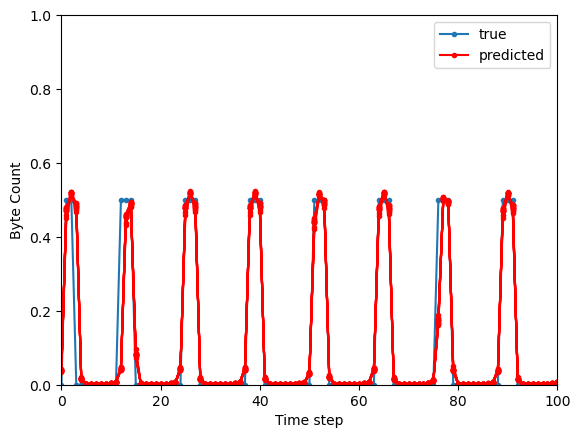

In [20]:
plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred_67, 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [147]:
X_train_2, y_train_2 = batch(train, train['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_2, y_test_2 = batch(test, test['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

In [148]:
history_to80 = model.fit(X_train_2, y_train_2,
                          epochs = 30,
                          batch_size = 10,
                          validation_split = 0.1,
                          shuffle = False,
                          verbose = 1)

Epoch 1/30
97/97 [==============================] - 1s 6ms/step - loss: 0.0283 - val_loss: 0.0114
Epoch 2/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0113
Epoch 3/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0113
Epoch 4/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0114
Epoch 5/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0114
Epoch 6/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.0115
Epoch 7/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0148 - val_loss: 0.0116
Epoch 8/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0117
Epoch 9/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0118
Epoch 10/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0140 - val_loss: 0.0119
Epoch 11/30
97/97 [

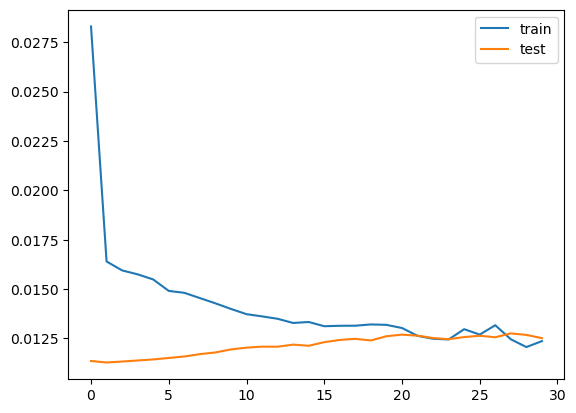

In [162]:
plt.plot(history_to80.history['loss'], label='train')
plt.plot(history_to80.history['val_loss'], label='test')
plt.legend()
plt.show()

In [150]:
y_pred_toint80 = model.predict(X_test_2)

9/9 [==============================] - 0s 3ms/step


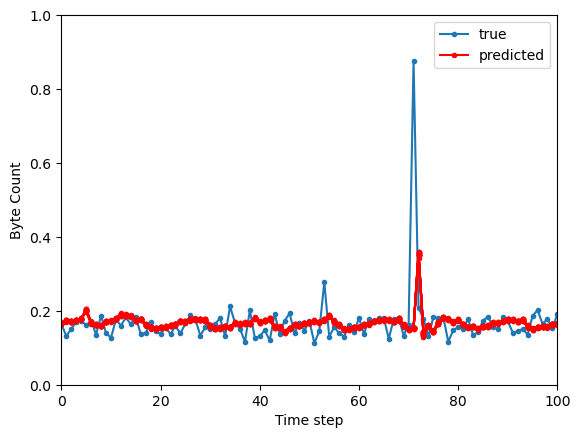

In [151]:
plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test_2, marker='.', label='true')
plt.plot(y_pred_toint80, 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [153]:
X_train_3, y_train_3 = batch(train, train['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_3, y_test_3 = batch(test, test['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

In [154]:
history_toint1024 = model.fit(X_train_3, y_train_3,
                          epochs = 30,
                          batch_size = 10,
                          validation_split = 0.1,
                          shuffle = False,
                          verbose = 1)

Epoch 1/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 2/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 3/30
97/97 [==============================] - 1s 6ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 4/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 5/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 6/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 7/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 8/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 9/30
97/97 [==============================] - 1s 6ms/step - loss: 0.0131 - val_loss: 0.0143
Epoch 10/30
97/97 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 11/30
97/97 [

In [155]:
y_pred_toint1024 = model.predict(X_test_3)

9/9 [==============================] - 0s 3ms/step


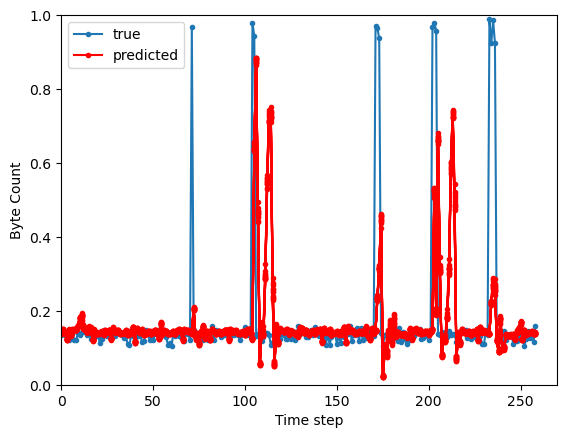

In [211]:
plt.xlim(0,270)
plt.ylim(0,1.0)
plt.plot(y_test_3, marker='.', label='true')
plt.plot(y_pred_toint1024, 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [160]:
def calc_euclidean(actual, prediction):
    return np.sqrt(np.sum((actual - prediction) ** 2))

def calc_mape(actual, prediction):
    return np.mean(np.abs((actual - prediction) / actual))

In [177]:
# pearson correlation coefficient
def calc_correlation(actual, prediction):
    a_diff = actual - np.mean(actual)
    p_diff = prediction = np.mean(prediction)
    numerator = np.sum(a_diff * p_diff)
    denominator = np.sqrt(np.sum(a_diff ** 2)) * np.sqrt(np.sum(p_diff ** 2))
    return numerator / denominator

In [199]:
p_67 = y_pred_67.flatten()
plt.plot(y_test_3, marker='.', label='true')

In [217]:
p_80 = y_pred_toint80.flatten()
df_80 = pd.DataFrame(p_80)

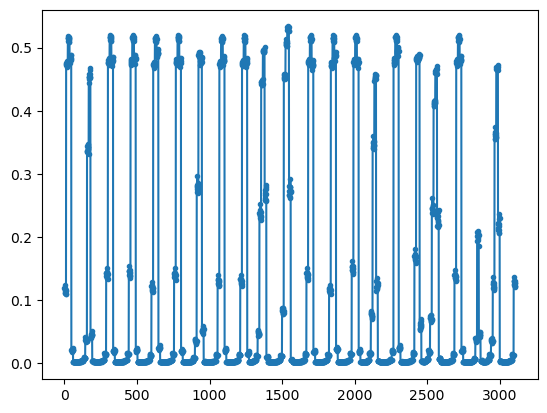

In [216]:
plt.plot(df_67, marker='.', label='true')

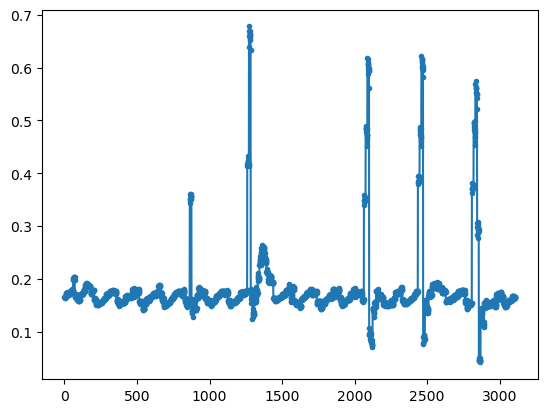

In [220]:
plt.plot(df_80, marker='.')

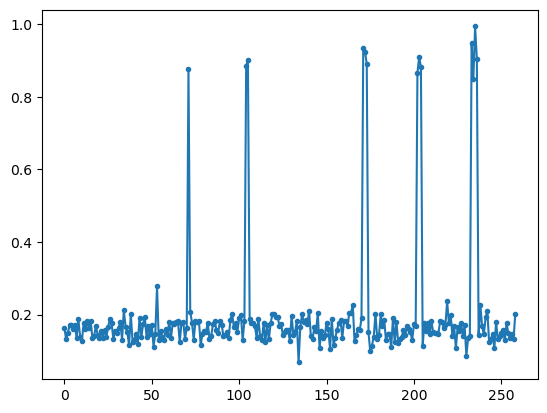

In [221]:
plt.plot(y_test_2, marker='.')

In [230]:
p_1024 = y_pred_toint1024.flatten()
df_1024 = pd.DataFrame(p_1024)

In [225]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# Larger value is better

distance, path = fastdtw(y_test, df_67, dist=euclidean)

In [228]:
distance_80, path = fastdtw(y_test_2, df_80, dist=euclidean)
distance_80

74.2647945859496

In [229]:
distance

470.7908715260421

In [231]:
distance_1024, path = fastdtw(y_test_3, p_1024)
distance_1024

107.29837024030164